In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
# from torch.utils.data import DataLoader as dataloader
import torch.utils.data.dataloader as dataloader
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from PIL import Image, ImageOps
import copy
import pandas as pd
import cv2

In [46]:
class CUB200(Dataset):
    
    def __init__(self, root, image_size, transform, test_train=1, return_masks=False):

        # Gets the path and loads class labels  
        class_list_path = os.path.join(root, "image_class_labels.txt")
        # Row = index, class
        self.data_df = pd.read_csv(class_list_path, sep=" ", names=["index", "class"])
        
        # Gets the file path and reads the file paths of the images
        data_list_path = os.path.join(root, "images.txt")
        # Row = index, file_path
        cub200_df = pd.read_csv(data_list_path, sep=" ", names=["index", "file_path"])
        
        # Gets the file path of the bounding boxes
        bbox_list_path = os.path.join(root, "bounding_boxes.txt")
        # Row = index, x, y, width, height
        bbox_df = pd.read_csv(bbox_list_path, sep=" ", names=["index", "x", "y", "width", "height"])
        
        # Use custom test/train split 1/0
        # Merges on the "index" name
        split_df = pd.read_csv("test_train_split.txt", sep=" ", names=["index", "split"])

        self.data_df = self.data_df.merge(cub200_df, left_on='index', right_on='index')
        self.data_df = self.data_df.merge(bbox_df, left_on='index', right_on='index')
        self.data_df = self.data_df.merge(split_df, left_on='index', right_on='index')

        # Final dataframe
        self.data_df = self.data_df[self.data_df.split != test_train]

        # self.return_masks = return_masks
        self.image_size = image_size
        self.transform = transform

        self.root = root
        self.image_root_dir = os.path.join(self.root, "images")

    # Takes in a single row example from final dataframe, returns box_coords as (x1, y1, x2, y2)
    def get_bbox_list(self, data, img_size):
        bbox_array = [data["x"],
                      data["y"],
                      data["width"],
                      data["height"]]
        
        # If the box is outside of the image in either direction x or y, adjust width to be the length up to the edge
        # Calculates bbox_array to be within the image
        if (bbox_array[0] + bbox_array[2]) > img_size[1]:
            bbox_array[2] = img_size[1] - bbox_array[0]

        if (bbox_array[1] + bbox_array[3]) > img_size[0]:
            bbox_array[3] = img_size[0] - bbox_array[1]

        return [bbox_array]

    # Gets the number of output tensors and matches it to 4 coordinate outputs
    def get_output_tensors(self, data_out):
        if len(data_out["bboxes"]) > 0:
            # Get
            bbox = torch.FloatTensor(data_out["bboxes"][0]) / self.image_size
            label = data_out["class_labels"][0]
        else:
            bbox = torch.zeros(4)
            label = -1

        return bbox, [label]

    # Gets an item from the dataloader
    def __getitem__(self, index):
        
        # Gets a single row. Allowing for indexing like a list
        data_series = self.data_df.iloc("index")[index]
        # Gets file path
        file_path = data_series["file_path"]
        # Gets label
        label = data_series["class"]

        # Build the file path
        img_path = os.path.join(self.image_root_dir, file_path)
        # Read image and process
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Pass in the row to the dataframe, and the image's shape
        # Gets the bbox dimensions as a list [x, y, width, height]
        bbox_array = self.get_bbox_list(data_series, image.shape)
        
        # Preprocess the datapoints using the transform pipeline
        # Not sure what transform returns!
        data_out = self.transform(image=image, bboxes=bbox_array, class_labels=[label])
        # Convert the bbox and label to an output tensor, which is returned as an item when dataloader is iterated upon
        bbox, label = self.get_output_tensors(data_out)
        return data_out["image"], bbox, label

    def __len__(self):
        return len(self.data_df)

In [47]:
batch_size = 64

num_epochs = 10

learning_rate = 1e-4

root = "../../data/CUB_200_2011"

image_size = 128

In [48]:
start_from_checkpoint = False

save_dir = '.'

model_name = 'ResNet34_CUB'

device = 'cpu'

In [49]:
# Data augmentation pipeline
train_transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                             A.RandomCrop(height=image_size, width=image_size),
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                             A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                            ToTensorV2()], 
                            # Specifies parameters for handling bounding boxes
                            # COCO -> (x_min, y_min, width, height)
                            # min_area to be considered = 0
                            # visibility of box = 0
                            # Specify corresponding labels
                            bbox_params=A.BboxParams(format='coco',
                                                     min_area=0, min_visibility=0.0, 
                                                     label_fields=['class_labels']))

transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                       A.RandomCrop(height=image_size, width=image_size),
                       A.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
                       ToTensorV2()], 
                      bbox_params=A.BboxParams(format='coco',
                                               min_area=0, min_visibility=0.0, 
                                               label_fields=['class_labels']))

In [50]:
# nn.Module class that will return the IoU for a batch of outputs
class BboxIOU(nn.Module):

    # Converts xyhw to xyxy coordinates
    def xyhw_to_xyxy(self, bbox):
        """
        Converts from (x_min, y_min, width, height) to (x_min, y_min, x_max, y_max) format
        """
        # [(), (), (), ()]
        new_bbox = torch.cat((bbox[:, 0:1], 
                              bbox[:, 1:2],
                              bbox[:, 2:3] + bbox[:, 0:1], 
                              bbox[:, 3:4] + bbox[:, 1:2]), 1)
        return new_bbox

    # Calculates the intersection abs area
    def bb_intersection_over_union(self, pred_xyhw, target_xyhw):
        pred_xyxy = self.xyhw_to_xyxy(pred_xyhw) # [(), (), (), ()]
        target_xyxy = self.xyhw_to_xyxy(target_xyhw) # [(), (), (), ()]
        
        # Determine the (x, y) - coordinates of the intersection rectangle
        # (x_min, y_min, x_max, y_max)
        xA = torch.cat((pred_xyxy[:, 0:1], target_xyxy[:, 0:1]), 1).max(dim=1)[0].unsqueeze(1) # Max of x_min
        yA = torch.cat((pred_xyxy[:, 1:2], target_xyxy[:, 1:2]), 1).max(dim=1)[0].unsqueeze(1) # Max of y_min
        xB = torch.cat((pred_xyxy[:, 2:3], target_xyxy[:, 2:3]), 1).min(dim=1)[0].unsqueeze(1) # Max of x_max
        yB = torch.cat((pred_xyxy[:, 3:4], target_xyxy[:, 3:4]), 1).min(dim=1)[0].unsqueeze(1) # Max of y_max

        # Compute the area of intersection rectangle
        x_len = F.relu(xB - xA)
        y_len = F.relu(yB - yA)
        
        # Negative area means no overlap
        interArea = x_len * y_len

#       If you don't have xyhw values, calculate areas like this
#       w1 = (pred_xyxy[:, 0:1] - pred_xyxy[:, 2:3]).abs()
#       h1 = (pred_xyxy[:, 1:2] - pred_xyxy[:, 3:4]).abs()

#       w2 = (target_xyxy[:, 0:1] - target_xyxy[:, 2:3]).abs()
#       h2 = (target_xyxy[:, 1:2] - target_xyxy[:, 3:4]).abs()

#         area1 = w1 * h1
#         area2 = w2 * h2

        # Predicted and target box areas
        area1 = pred_xyhw[:, 2:3] * pred_xyhw[:, 3:4]
        area2 = target_xyhw[:, 2:3] * target_xyhw[:, 3:4]

        # Compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        iou = interArea / (area1 + area2 - interArea + 1e-5)

        # Return the intersection over union value
        return iou

    # !!! Not exactly sure what this is for
    def forward(self, predictions, images, coords):
        """
        data: list of data, index 0 is the input image index [0] is the target
        predictions: raw output of the model, the first 4 outputs are assumed to be the bounding box values
        """
        pred_bbox = torch.sigmoid(predictions[:, :4])
        target_bbox = coords.to(pred_bbox.device)
        
        return self.bb_intersection_over_union(pred_bbox, target_bbox)

In [51]:
# Initalize our datasets # (#, idx, class, file_path, x, y, width, height, split)
train_data = CUB200(root, image_size=image_size, transform=train_transform, test_train = 0)
test_data = CUB200(root, image_size=image_size, transform=transform, test_train = 1)

In [53]:
train_data.data_df

,index,class,file_path,x,y,width,height,split
1,2,1,001.Black_footed_Albatross/Black_Footed_Albatr...,139.0,30.0,153.0,264.0,1
3,4,1,001.Black_footed_Albatross/Black_Footed_Albatr...,112.0,90.0,255.0,242.0,1
5,6,1,001.Black_footed_Albatross/Black_Footed_Albatr...,33.0,53.0,251.0,395.0,1
6,7,1,001.Black_footed_Albatross/Black_Footed_Albatr...,7.0,75.0,420.0,262.0,1
7,8,1,001.Black_footed_Albatross/Black_Footed_Albatr...,78.0,86.0,333.0,158.0,1
...,...,...,...,...,...,...,...,...
11783,11784,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,89.0,95.0,354.0,250.0,1
11784,11785,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,157.0,62.0,184.0,219.0,1
11785,11786,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,190.0,102.0,198.0,202.0,1
11786,11787,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,3.0,20.0,408.0,307.0,1


In [54]:
test_data.data_df

,index,class,file_path,x,y,width,height,split
0,1,1,001.Black_footed_Albatross/Black_Footed_Albatr...,60.0,27.0,325.0,304.0,0
2,3,1,001.Black_footed_Albatross/Black_Footed_Albatr...,14.0,112.0,388.0,186.0,0
4,5,1,001.Black_footed_Albatross/Black_Footed_Albatr...,70.0,50.0,134.0,303.0,0
15,16,1,001.Black_footed_Albatross/Black_Footed_Albatr...,141.0,87.0,256.0,211.0,0
16,17,1,001.Black_footed_Albatross/Black_Footed_Albatr...,40.0,38.0,254.0,209.0,0
...,...,...,...,...,...,...,...,...
11770,11771,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,168.0,107.0,245.0,147.0,0
11771,11772,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,272.0,72.0,155.0,388.0,0
11775,11776,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,11.0,89.0,383.0,171.0,0
11776,11777,200,200.Common_Yellowthroat/Common_Yellowthroat_00...,121.0,168.0,284.0,148.0,0


In [57]:
# Split 90% - 10%
validation_split = 0.9

# Total train examples
n_train_examples = int(len(train_data) * validation_split)

# Total validation examples
n_valid_examples = len(train_data) - n_train_examples

# Splits them based on values provided
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.Generator().manual_seed(42))

In [148]:
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = dataloader.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [190]:
# The first is a tensor of images
# The second is a tensor of corresonding coordinates
# The last is a label of the corresponding class (what type of bird is it)
x,y,z = next(iter(train_loader))
x.shape, y.shape, z

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 4]),
 [tensor([ 33, 115,  23,  87, 115,  51,  74,  66, 103, 182,  25, 133, 114, 199,
           52,  58,  77, 171,  58,  29, 116,  28, 176, 190, 107, 123,  33,  34,
           40,  29,  17,  52,  69,  53, 175, 156, 154, 168, 116, 186, 132, 186,
          138,  28, 117,  68,   8,  80,  27, 148,  45, 122, 112,  91, 192,  63,
          193,  38, 192,  95,  30,  96, 174, 181])])

In [178]:
for batch in train_loader:
    images, coords, labels = batch
    print(images.shape)
    break

torch.Size([64, 3, 128, 128])


In [193]:
class NetworkConstructor(nn.Module):
    # Make sure that the correct number of arguments are being passed through
    def __init__(self, model, device, batch_size, learning_rate, optimizer, loss_function, eval_metric, save_dir, output_size,
                 train_loader, valid_loader, test_loader, start_from_checkpoint):
        super(NetworkConstructor, self).__init__()

        # Parameters and model functionalites
        self.device = device
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.train_loss = []
        self.train_acc = []
        self.valid_acc = []

        # Dataloaders
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        # To update the pretrained model's output_size and update its last layer
        self.output_size = output_size
        self.model = self.change_output(model, output_size=output_size)

        # Full filename
        self.save_path = os.path.join(save_dir, model_name + ".pt")
        self.save_dir = save_dir

        self.lr_schedule = None
        self.eval_metric = eval_metric

        # Create save path from save_dir and model_name, we will save and load our checkpoint here
        # Create the save directory if it does note exist
        if not os.path.isdir(self.save_dir):
            os.makedirs(self.save_dir)
        # Loads checkpoint if starting from checkpoint is True
        if start_from_checkpoint:
            self.load_checkpoint()
        else:
            # If checkpoint does exist and start_from_checkpoint = False
            # Raise an error to prevent accidental overwriting
            if os.path.isfile(self.save_path):
                raise ValueError("Warning Checkpoint exists")
            else:
                print("Initalized model")

    # Update the output to output output_size classes
    def change_output(self, model, output_size):
        num_ftrs = model.fc.in_features
        layer = nn.Linear(num_ftrs, output_size).to(self.device)
        model.fc = layer
        return model

### ------------------------------------------------------------------------------------------------------

    def load_checkpoint(self):
        # Check if checkpoint exists
        if os.path.isfile(self.save_path):
            # Load Checkpoint
            check_point = torch.load(self.save_path)
            # Here we unpack the dictionary to get our previous training states
            self.model.load_state_dict(check_point['model_state_dict'])
            print("Checkpoint loaded, starting from epoch:", self.start_epoch)
        else:
            # Raise Error if it does not exist
            raise ValueError("Checkpoint Does not exist")

    def save_checkpoint(self, epoch, valid_acc):
        torch.save({
            'model_state_dict': self.model.state_dict(),
        }, self.save_path)

### ------------------------------------------------------------------------------------------------------

    # Training
    def train_model(self, num_epochs):
        print("training")
        for epoch in range(num_epochs):
            # Training mode
            self.train()
            
            for batch in self.train_loader:
                print("batch")
                images, coords, labels = batch
                
                # Forward pass of images through the network and get output
                logits = self.forward(images.to(self.device))
                
                # Calculate loss using loss function
                loss = self.loss_function(logits, coords.to(self.device))
                
                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 5)
                self.optimizer.step()
                
                # Log the loss for plotting
                self.train_loss.append(loss.item())
            
            # Print last loss of an epoch
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            
            # Evaluation mode for both train and validation accuracy
            self.eval()
            print("eval")
            # Calculate train accuracy
            train_total = 0
            with torch.no_grad():
                for batch in self.train_loader:
                    images, coords, labels = batch
                    logits = self.forward(images.to(self.device))
                    train_total += self.eval_metric(logits, images, coords).sum().item()
            
            train_acc = train_total / len(self.train_loader.dataset)
            self.train_acc.append(train_acc)
            
            # Calculate validation accuracy
            valid_total = 0
            with torch.no_grad():
                for batch in self.valid_loader:
                    images, coords, labels = batch
                    logits = self.forward(images.to(self.device))
                    valid_total += self.eval_metric(logits, images, coords).sum().item()
            
            valid_acc = valid_total / len(self.valid_loader.dataset)
            self.valid_acc.append(valid_acc)
            
            # Print epoch summary
            print(f"Epoch {epoch} | Train Accuracy: {train_acc:.4f} | Valid Accuracy: {valid_acc:.4f}")

    def forward(self, x):
        return self.model(x)

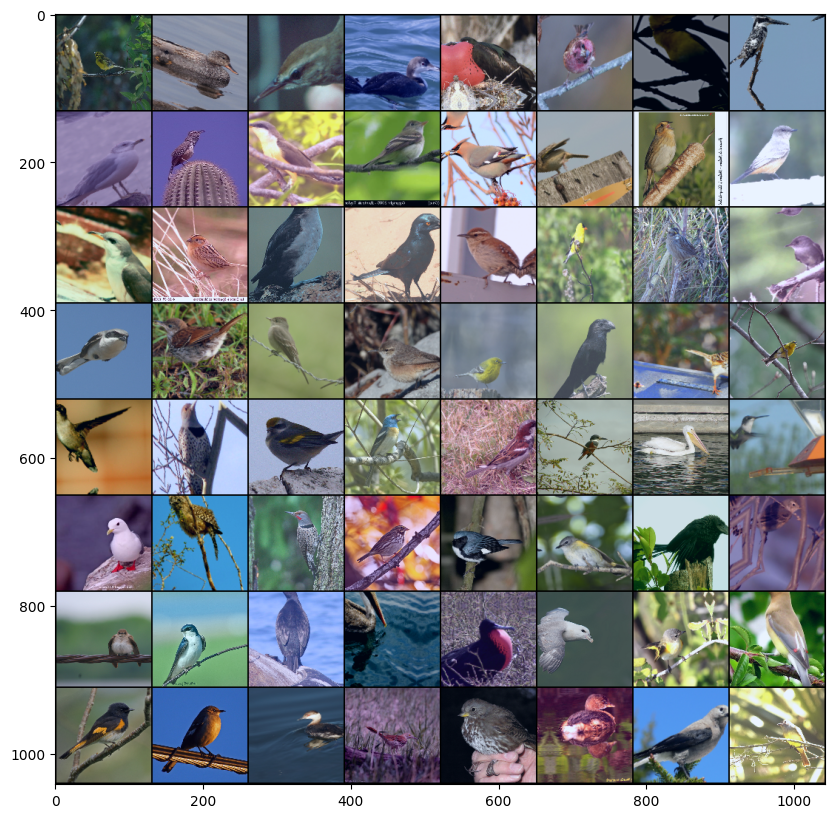

In [181]:
plt.figure(figsize = (20,10))
images, bbox, labels = next(iter(model_trainer.train_loader))
images.shape
out = torchvision.utils.make_grid(images, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

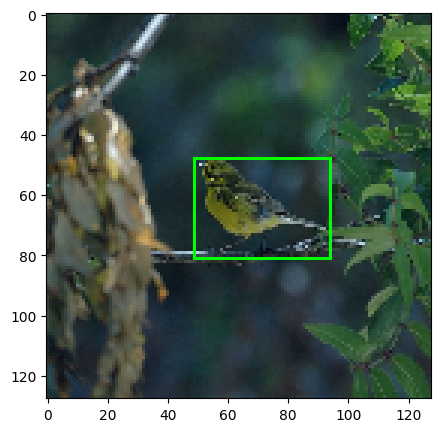

In [194]:
example_indx = 0
ex_img = images[example_indx]

# The bounding box is represented in the (x_min, y_min, width, height) format
# aka the coordinate of the top left corner of the box and the box height and width

# draw_bounding_boxes expects it in the (x_min, y_min, x_max, y_max) formatweights=ResNet18_Weights.IMAGENET1K_V1
# aka the coordinates of the top left and bottom right corners of the box
ex_label = bbox[example_indx].unsqueeze(0) * image_size
ex_label[:, 2] += ex_label[:, 0]
ex_label[:, 3] += ex_label[:, 1]

img_out = (((ex_img - ex_img.min())/(ex_img.max() - ex_img.min())) * 255).to(torch.uint8)
img_box = torchvision.utils.draw_bounding_boxes(img_out, ex_label, colors=(0, 255, 0))

plt.figure(figsize = (5,5))
out = torchvision.utils.make_grid(img_box.unsqueeze(0).float(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [183]:
# Create an instance of the ResNet34 Model
# resnet = models.resnet34(pretrained=True)
resnet = models.resnet34(weights="IMAGENET1K_V1")

In [184]:
loss_function=nn.BCEWithLogitsLoss()

In [185]:
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

In [195]:
model_trainer = NetworkConstructor(model=resnet.to(device), device=device, batch_size = batch_size, learning_rate = learning_rate,
                    optimizer = optimizer, loss_function = loss_function, eval_metric = BboxIOU(), save_dir = save_dir, output_size = 4,
                    train_loader = train_loader, valid_loader = valid_loader, test_loader = test_loader, start_from_checkpoint = start_from_checkpoint)

Initalized model


In [196]:
model_trainer.train_model(num_epochs=num_epochs)

training
batch
batch
batch
batch
batch
batch



KeyboardInterrupt



In [198]:
# print("The highest validation IoU was %.2f" %(model_trainer.best_valid_acc))

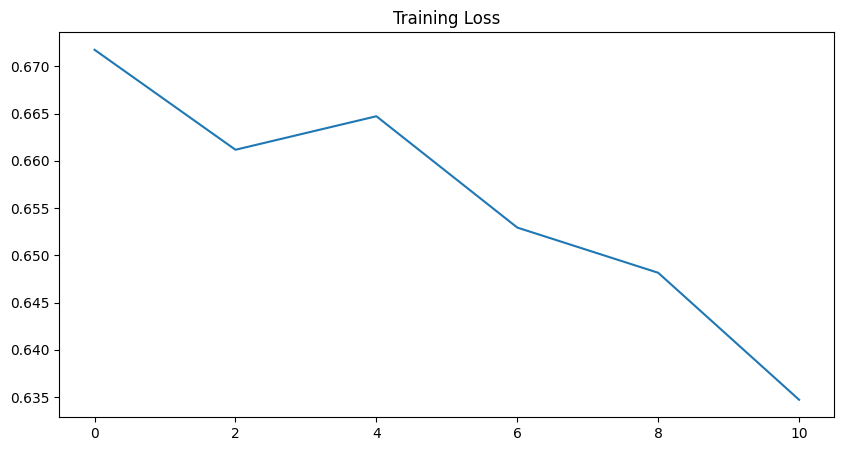

In [201]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_loss))
_ = plt.plot(train_x, model_trainer.train_loss)
_ = plt.title("Training Loss")

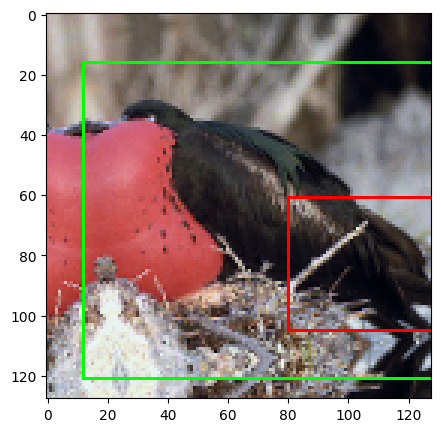

In [203]:
# Select an image to test
example_indx = 4
ex_img = images[example_indx]
img_out = (((ex_img - ex_img.min())/(ex_img.max() - ex_img.min())) * 255).to(torch.uint8)

real_label = bbox[example_indx].unsqueeze(0) * image_size
real_label[:, 2] += real_label[:, 0]
real_label[:, 3] += real_label[:, 1]

# Get the model's prediction for the Bounding Box
model_trainer.eval()
with torch.no_grad():
    pred_out = torch.sigmoid(model_trainer(ex_img.unsqueeze(0).to(device)))
    pred_label = (pred_out * image_size).cpu()
    pred_label[:, 2] += pred_label[:, 0]
    pred_label[:, 3] += pred_label[:, 1]
    
# Draw the box on the image
img_box = torchvision.utils.draw_bounding_boxes(img_out, real_label, colors=(0, 255, 0))
img_box = torchvision.utils.draw_bounding_boxes(img_box, pred_label, colors=(255, 0, 0))

plt.figure(figsize = (5,5))
out = torchvision.utils.make_grid(img_box.unsqueeze(0).float(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [2]:
# _ = plt.figure(figsize = (10,5))
# train_x = np.linspace(0, num_epochs, len(model_trainer.train_acc))
# _ = plt.plot(train_x, model_trainer.train_acc, c = "y")
# valid_x = np.linspace(0, num_epochs, len(model_trainer.valid_acc))
# _ = plt.plot(valid_x, model_trainer.valid_acc, c = "k")

# _ = plt.title("Average IoU")
# _ = plt.legend(["Training IoU", "Validation IoU"])

In [1]:
# # Call the evaluate function and pass the evaluation/test dataloader etc
# test_acc = model_trainer.evaluate_model(train_test_val="test")
# print("The Test Average IoU is: %.2f" %(test_acc))